In [30]:
import numpy as np 
import pandas as pd 

In [31]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import IsolationForest
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from statsmodels.tsa.statespace.sarimax import SARIMAX
from prophet import Prophet
from sklearn.metrics import mean_squared_error, mean_absolute_error
import statsmodels.api as sm
from sklearn.ensemble import RandomForestRegressor
from sklearn.inspection import permutation_importance
import statsmodels.api as sm
import warnings
warnings.filterwarnings("ignore")

In [32]:
df=pd.read_csv('/kaggle/input/global-weather-repository/GlobalWeatherRepository.csv')
df

,country,location_name,latitude,longitude,timezone,last_updated_epoch,last_updated,temperature_celsius,temperature_fahrenheit,condition_text,...,air_quality_PM2.5,air_quality_PM10,air_quality_us-epa-index,air_quality_gb-defra-index,sunrise,sunset,moonrise,moonset,moon_phase,moon_illumination
0,Afghanistan,Kabul,34.5200,69.1800,Asia/Kabul,1715849100,2024-05-16 13:15,26.6,79.8,Partly Cloudy,...,8.400,26.600,1,1,04:50 AM,06:50 PM,12:12 PM,01:11 AM,Waxing Gibbous,55
1,Albania,Tirana,41.3300,19.8200,Europe/Tirane,1715849100,2024-05-16 10:45,19.0,66.2,Partly cloudy,...,1.100,2.000,1,1,05:21 AM,07:54 PM,12:58 PM,02:14 AM,Waxing Gibbous,55
2,Algeria,Algiers,36.7600,3.0500,Africa/Algiers,1715849100,2024-05-16 09:45,23.0,73.4,Sunny,...,10.400,18.400,1,1,05:40 AM,07:50 PM,01:15 PM,02:14 AM,Waxing Gibbous,55
3,Andorra,Andorra La Vella,42.5000,1.5200,Europe/Andorra,1715849100,2024-05-16 10:45,6.3,43.3,Light drizzle,...,0.700,0.900,1,1,06:31 AM,09:11 PM,02:12 PM,03:31 AM,Waxing Gibbous,55
4,Angola,Luanda,-8.8400,13.2300,Africa/Luanda,1715849100,2024-05-16 09:45,26.0,78.8,Partly cloudy,...,183.400,262.300,5,10,06:12 AM,05:55 PM,01:17 PM,12:38 AM,Waxing Gibbous,55
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
58848,Venezuela,Caracas,10.5000,-66.9167,America/Caracas,1742031900,2025-03-15 05:45,25.2,77.4,Partly cloudy,...,12.580,14.985,1,2,06:34 AM,06:38 PM,07:49 PM,07:19 AM,Waning Gibbous,99
58849,Vietnam,Hanoi,21.0333,105.8500,Asia/Bangkok,1742031900,2025-03-15 16:45,26.4,79.5,Mist,...,60.680,65.860,3,8,06:05 AM,06:06 PM,07:00 PM,06:30 AM,Waning Gibbous,100
58850,Yemen,Sanaa,15.3547,44.2067,Asia/Aden,1742031900,2025-03-15 12:45,22.1,71.7,Sunny,...,30.525,160.580,2,3,06:11 AM,06:13 PM,07:13 PM,06:43 AM,Waning Gibbous,100
58851,Zambia,Lusaka,-15.4167,28.2833,Africa/Lusaka,1742031900,2025-03-15 11:45,22.5,72.5,Patchy rain nearby,...,8.325,8.695,1,1,06:10 AM,06:21 PM,07:06 PM,06:54 AM,Waning Gibbous,100


In [33]:
# Convert date features to datetime
df['last_updated'] = pd.to_datetime(df['last_updated'], errors='coerce')
df['sunrise'] = pd.to_datetime(df['sunrise'], format='%H:%M', errors='coerce').dt.time
df['sunset'] = pd.to_datetime(df['sunset'], format='%H:%M', errors='coerce').dt.time
df['moonrise'] = pd.to_datetime(df['moonrise'], format='%H:%M', errors='coerce').dt.time
df['moonset'] = pd.to_datetime(df['moonset'], format='%H:%M', errors='coerce').dt.time

In [34]:
# For time series analysis, set last_updated as index
df = df.set_index('last_updated').sort_index()

# Select only numeric columns for advanced EDA and anomaly detection.
num_cols = df.select_dtypes(include=[np.number]).columns

In [35]:
# Check for missing or infinite values
print("NaN count per numeric column:")
print(df[num_cols].isna().sum())
print("\nInfinite count per numeric column:")
print(np.isinf(df[num_cols]).sum())

NaN count per numeric column:
latitude                        0
longitude                       0
last_updated_epoch              0
temperature_celsius             0
temperature_fahrenheit          0
wind_mph                        0
wind_kph                        0
wind_degree                     0
pressure_mb                     0
pressure_in                     0
precip_mm                       0
precip_in                       0
humidity                        0
cloud                           0
feels_like_celsius              0
feels_like_fahrenheit           0
visibility_km                   0
visibility_miles                0
uv_index                        0
gust_mph                        0
gust_kph                        0
air_quality_Carbon_Monoxide     0
air_quality_Ozone               0
air_quality_Nitrogen_dioxide    0
air_quality_Sulphur_dioxide     0
air_quality_PM2.5               0
air_quality_PM10                0
air_quality_us-epa-index        0
air_quality_gb-def

In [36]:
# Replace infinite values with NaN for numeric columns
df[num_cols] = df[num_cols].replace([np.inf, -np.inf], np.nan)

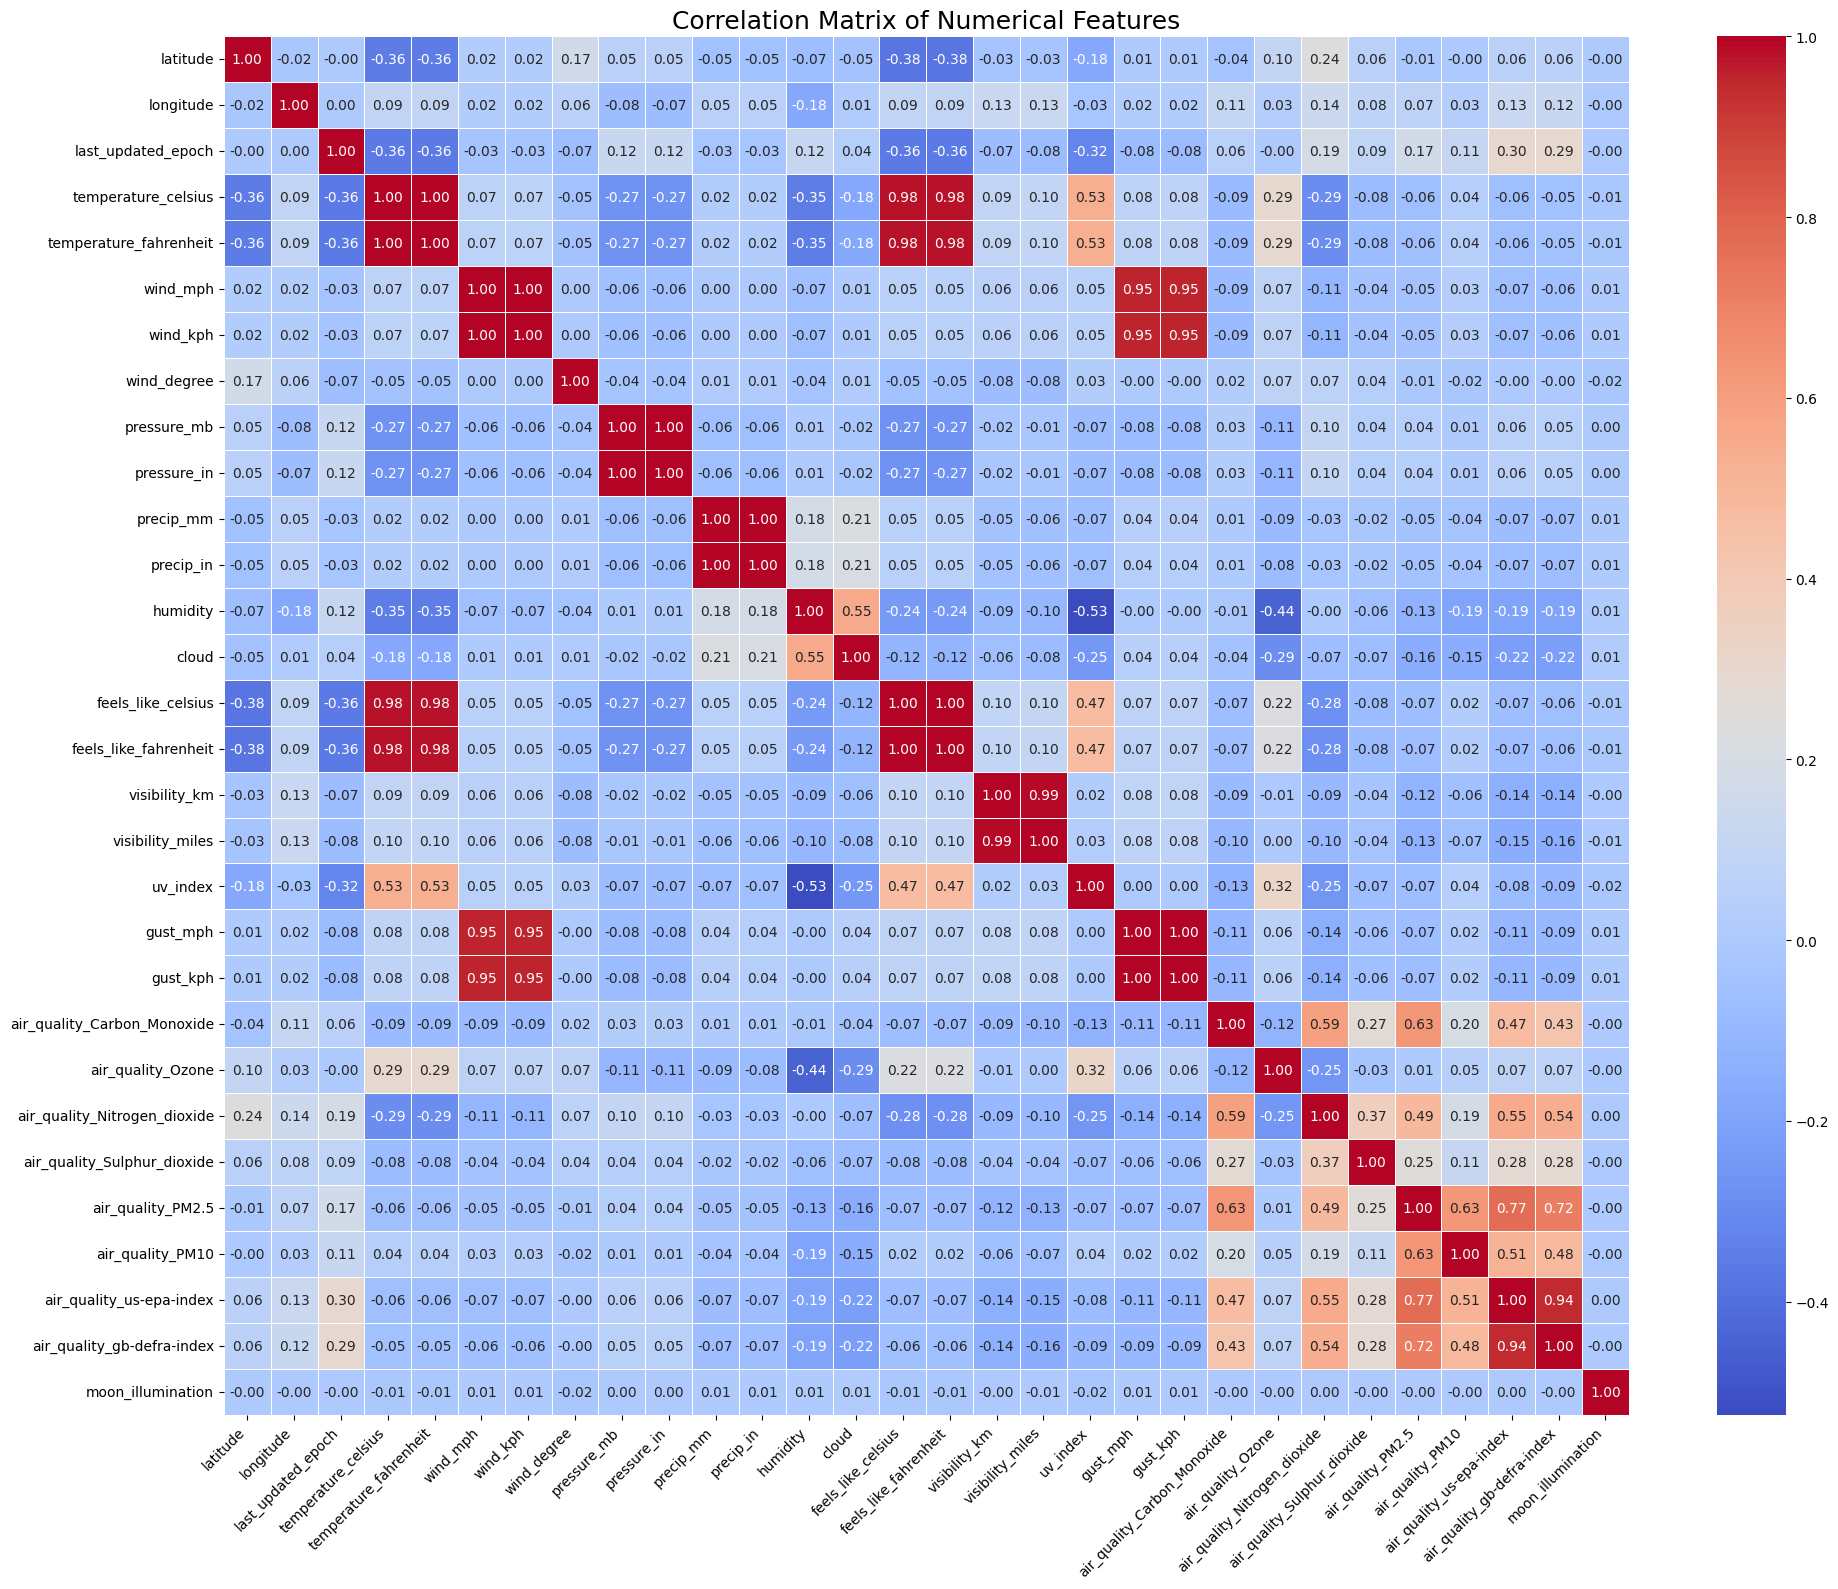

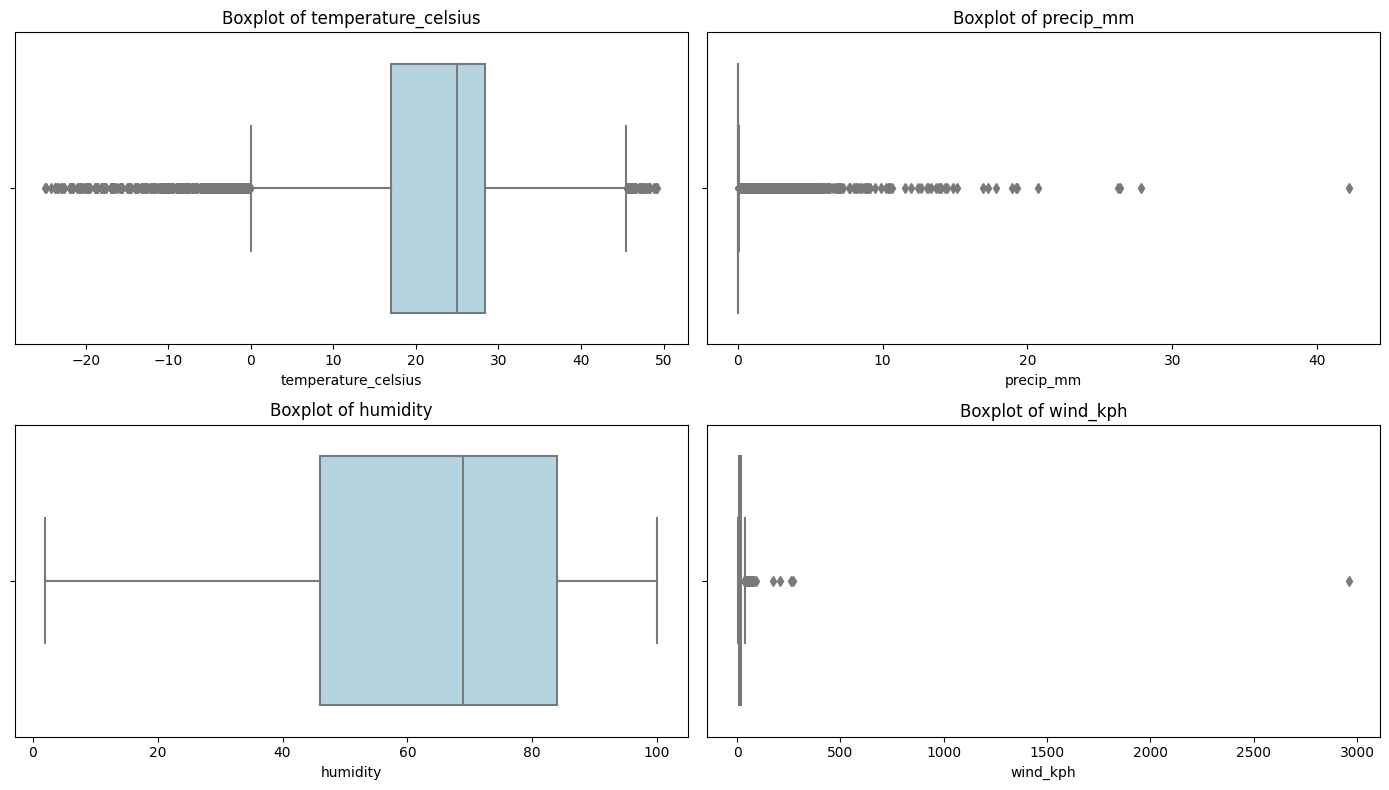

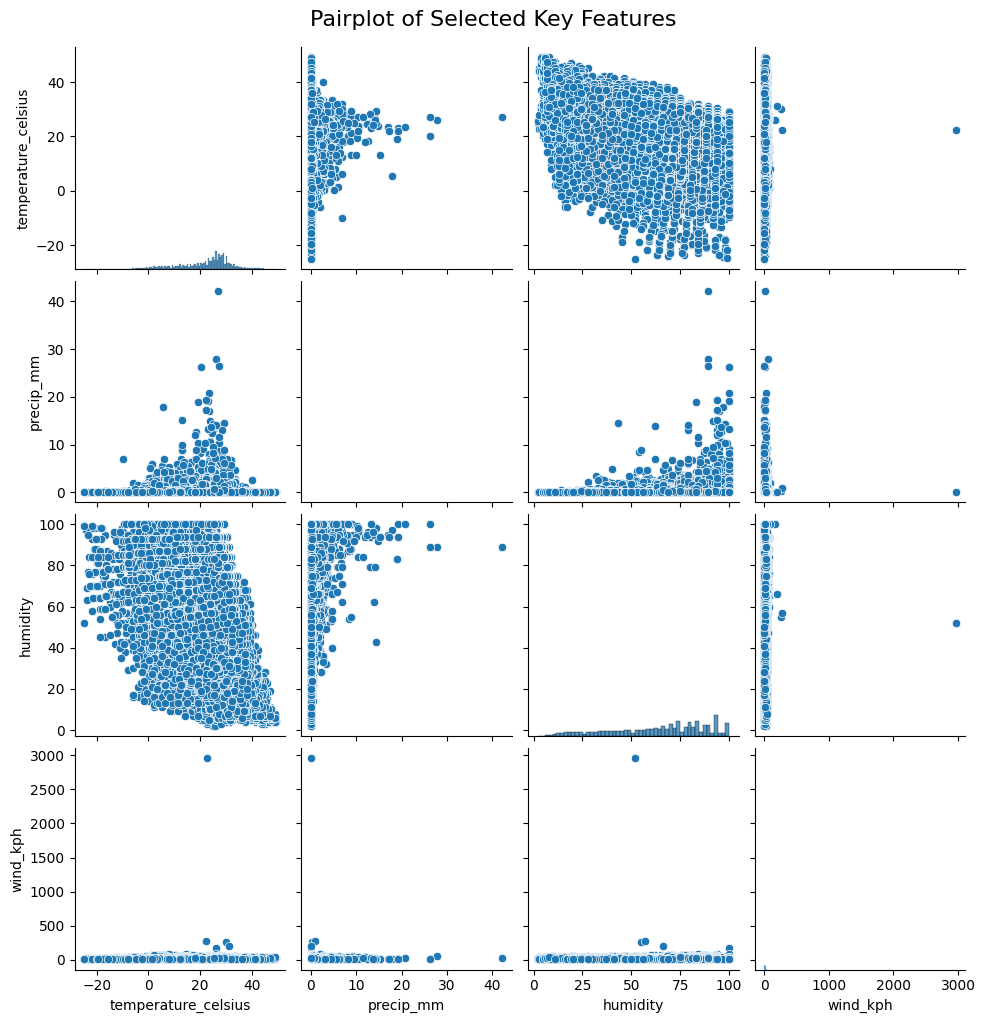

In [37]:
# ======= Advanced EDA =======
# 1. Correlation Heatmap
plt.figure(figsize=(20, 16))
corr_matrix = df[num_cols].corr()
sns.heatmap(corr_matrix, cmap='coolwarm', annot=True, fmt=".2f", linewidths=0.5)
plt.title("Correlation Matrix of Numerical Features", fontsize=18)
plt.xticks(rotation=45, ha='right', fontsize=10)
plt.yticks(rotation=0, fontsize=10)
plt.tight_layout()
plt.show()

# 2. Boxplots to examine distributions and potential outliers for selected key features
key_features = ['temperature_celsius', 'precip_mm', 'humidity', 'wind_kph']
plt.figure(figsize=(14, 8))
for i, col in enumerate(key_features, 1):
    plt.subplot(2, 2, i)
    sns.boxplot(x=df[col], color='lightblue')
    plt.title(f"Boxplot of {col}", fontsize=12)
    plt.tight_layout()
plt.show()

# 3. Pairplot of key numerical features to see relationships
sns.pairplot(df[key_features])
plt.suptitle("Pairplot of Selected Key Features", fontsize=16, y=1.02)
plt.show()

In [38]:
# ======= Advanced Anomaly Detection =======
# Using Isolation Forest on numeric features

# Initialize the IsolationForest: contamination parameter defines expected fraction of anomalies.
iso_model = IsolationForest(contamination=0.01, random_state=42)
df['anomaly'] = iso_model.fit_predict(df[num_cols])
# Anomalies are labeled as -1, normal observations as 1.
print("\nAnomaly counts:")
print(df['anomaly'].value_counts())

# Add anomaly score for further analysis
df['anomaly_score'] = iso_model.decision_function(df[num_cols])

# Extract anomalies for further analysis
anomalies = df[df['anomaly'] == -1]
normal = df[df['anomaly'] == 1]


Anomaly counts:
anomaly
 1    58264
-1      589
Name: count, dtype: int64


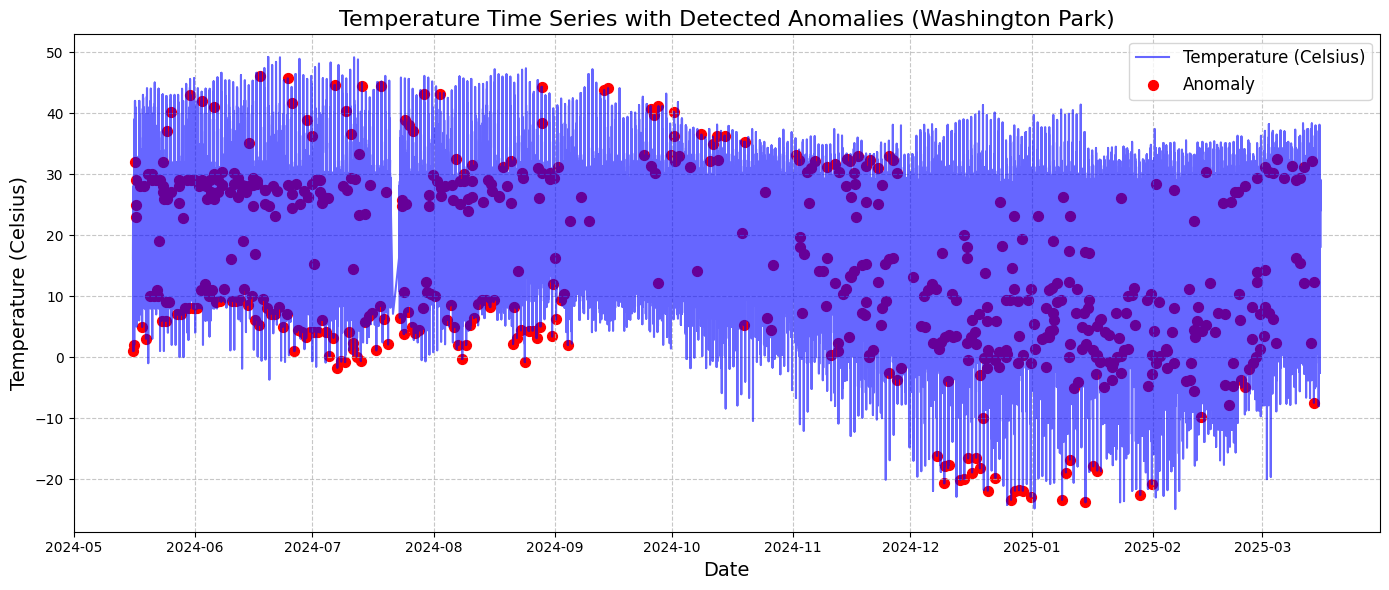

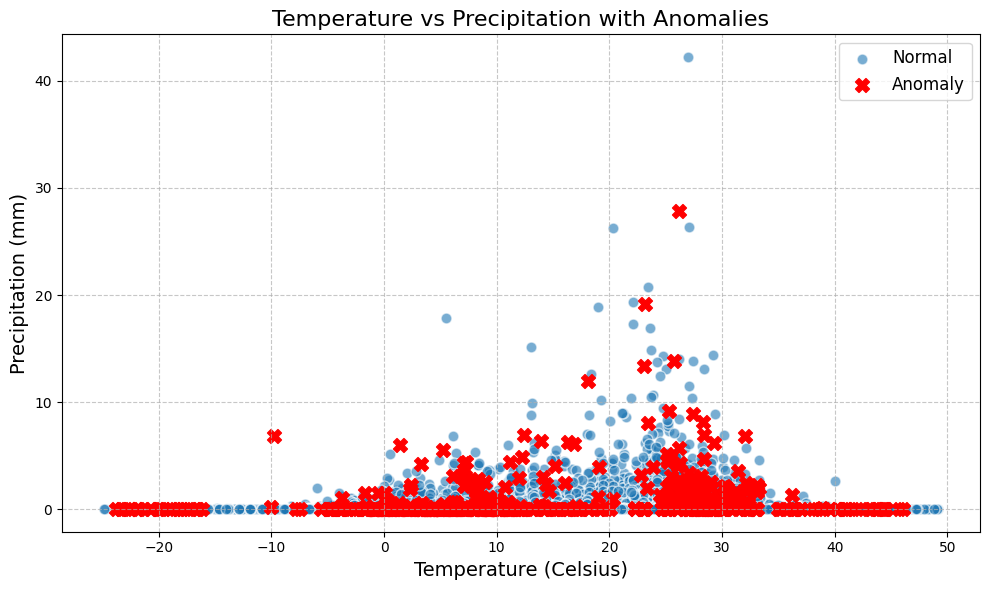

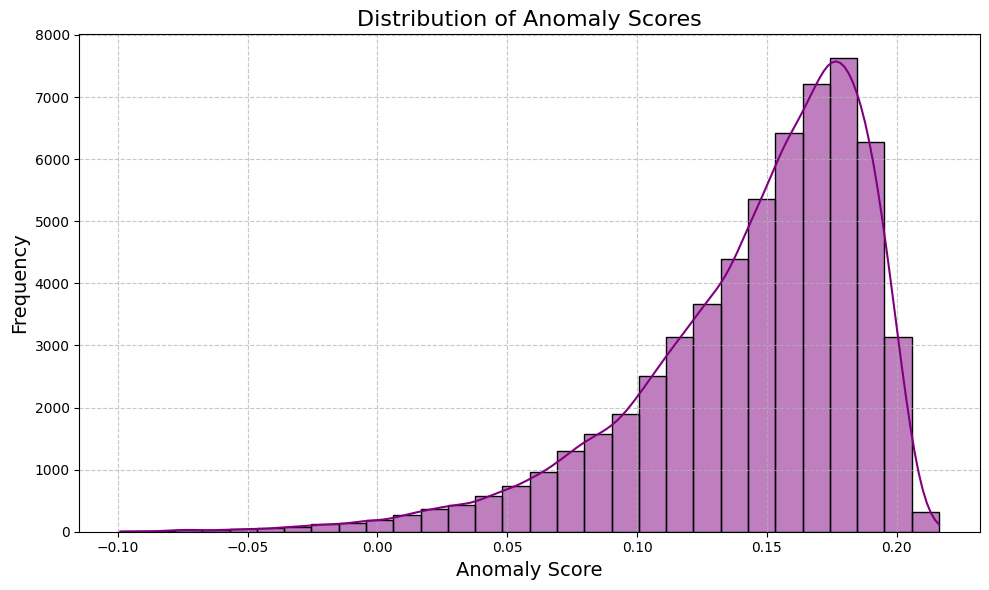

In [39]:
# ======= Visualization of Anomalies =======
# Define location if available
if 'location_name' in df.columns:
    location = df['location_name'].iloc[0]
else:
    location = "Unknown Location"

# Time Series Plot with Anomalies Highlighted
plt.figure(figsize=(14, 6))
plt.plot(df.index, df['temperature_celsius'], label='Temperature (Celsius)', color='blue', alpha=0.6)
plt.scatter(anomalies.index, anomalies['temperature_celsius'], color='red', label='Anomaly', marker='o', s=50)
plt.title(f"Temperature Time Series with Detected Anomalies ({location})", fontsize=16)
plt.xlabel("Date", fontsize=14)
plt.ylabel("Temperature (Celsius)", fontsize=14)
plt.legend(fontsize=12)
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


# 2. Scatter Plot of Temperature vs Precipitation with anomalies highlighted
plt.figure(figsize=(10, 6))
plt.scatter(normal['temperature_celsius'], normal['precip_mm'], label='Normal', alpha=0.6, edgecolors='w', s=60)
plt.scatter(anomalies['temperature_celsius'], anomalies['precip_mm'], label='Anomaly', color='red', marker='X', s=100)
plt.title("Temperature vs Precipitation with Anomalies", fontsize=16)
plt.xlabel("Temperature (Celsius)", fontsize=14)
plt.ylabel("Precipitation (mm)", fontsize=14)
plt.legend(fontsize=12)
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

# 3. Distribution of Anomaly Scores
plt.figure(figsize=(10, 6))
sns.histplot(df['anomaly_score'], kde=True, bins=30, color='purple')
plt.title("Distribution of Anomaly Scores", fontsize=16)
plt.xlabel("Anomaly Score", fontsize=14)
plt.ylabel("Frequency", fontsize=14)
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


In [40]:
# ======= Analyze Anomalies =======
# Print summary statistics of anomalies vs normal observations
print("\nSummary Statistics for Normal Observations:")
print(normal[num_cols].describe())
print("\nSummary Statistics for Anomalies:")
print(anomalies[num_cols].describe())


Summary Statistics for Normal Observations:
           latitude     longitude  last_updated_epoch  temperature_celsius  \
count  58264.000000  58264.000000        5.826400e+04         58264.000000   
mean      19.170512     21.904483        1.728969e+09            22.291295   
std       24.398539     65.641021        7.597491e+06             9.534626   
min      -41.300000   -175.200000        1.715849e+09           -24.900000   
25%        3.750000     -6.836100        1.722514e+09            17.100000   
50%       17.250000     23.316700        1.728985e+09            25.000000   
75%       40.400000     49.882200        1.735555e+09            28.500000   
max       64.150000    179.220000        1.742032e+09            49.200000   

       temperature_fahrenheit      wind_mph      wind_kph   wind_degree  \
count            58264.000000  58264.000000  58264.000000  58264.000000   
mean                72.125925      8.279013     13.327659    169.216652   
std                 17.1621

In [41]:
# Resample the data to daily frequency by taking the mean temperature per day.
# (We use 'temperature_celsius' as our target variable.)
daily_temp = df['temperature_celsius'].resample('D').mean().dropna()

# Split the data: Use all but the last 30 days for training, and reserve the final 30 days for testing.
train = daily_temp.iloc[:-30]
test = daily_temp.iloc[-30:]

In [42]:
# 2. Model Building and Forecasting


# ========= Model 1: ARIMA =========
arima_order = (1, 1, 1)  # Adjust order as needed
arima_model = ARIMA(train, order=arima_order)
arima_fit = arima_model.fit()
arima_forecast = arima_fit.forecast(steps=30)
# Force the ARIMA forecast to use the test index for alignment
arima_forecast.index = test.index

In [43]:
# ========= Model 2: Holt–Winters Exponential Smoothing =========
# Here, we use an additive trend without seasonality.
hw_model = ExponentialSmoothing(train, trend='add', seasonal=None)
hw_fit = hw_model.fit()
hw_forecast = hw_fit.forecast(steps=30)
# Force the Holt–Winters forecast to use the test index for alignment
hw_forecast.index = test.index

In [44]:
# ========= Model 3: Prophet =========
# Prophet requires a DataFrame with columns 'ds' (date) and 'y' (target)
train_prophet = pd.DataFrame({'ds': train.index, 'y': train.values})
prophet_model = Prophet(daily_seasonality=True)
prophet_model.fit(train_prophet)
# Create a future DataFrame for next 30 days
future = prophet_model.make_future_dataframe(periods=30, freq='D')
forecast_prophet_df = prophet_model.predict(future)
# Extract forecast for dates after the training period and reindex to test set
prophet_forecast = forecast_prophet_df[forecast_prophet_df['ds'] > train.index[-1]].set_index('ds')['yhat']
prophet_forecast = prophet_forecast.reindex(test.index)



10:24:34 - cmdstanpy - INFO - Chain [1] start processing
10:24:34 - cmdstanpy - INFO - Chain [1] done processing


In [45]:
# ========= Model 4: SARIMA =========
# Here, we use a seasonal ARIMA with seasonal_order (p,d,q,s)
sarima_order = (1, 1, 1)
seasonal_order = (1, 1, 1, 7) 
sarima_model = SARIMAX(train, order=sarima_order, seasonal_order=seasonal_order)
sarima_fit = sarima_model.fit(disp=False)
sarima_forecast = sarima_fit.forecast(steps=30)
sarima_forecast.index = test.index  # Align index

In [46]:
# ========= Ensemble Forecast =========
# Compute a simple average of all four forecasts
ensemble_forecast = (arima_forecast + hw_forecast + prophet_forecast + sarima_forecast) / 4

In [47]:
# ========= Debug: Check lengths =========
print("Length of Test Set:", len(test))
print("Length of ARIMA Forecast:", len(arima_forecast))
print("Length of Holt–Winters Forecast:", len(hw_forecast))
print("Length of Prophet Forecast:", len(prophet_forecast))
print("Length of SARIMA Forecast:", len(sarima_forecast))
print("Length of Ensemble Forecast:", len(ensemble_forecast))

Length of Test Set: 30
Length of ARIMA Forecast: 30
Length of Holt–Winters Forecast: 30
Length of Prophet Forecast: 30
Length of SARIMA Forecast: 30
Length of Ensemble Forecast: 30


In [48]:
# ========= Evaluation =========
def evaluate_forecast(actual, predicted, model_name):
    rmse = np.sqrt(mean_squared_error(actual, predicted))
    mae = mean_absolute_error(actual, predicted)
    print(f"{model_name} - RMSE: {rmse:.3f}, MAE: {mae:.3f}")
    return rmse, mae

print("Evaluation on Test Set:")
arima_rmse, arima_mae = evaluate_forecast(test, arima_forecast, "ARIMA")
hw_rmse, hw_mae = evaluate_forecast(test, hw_forecast, "Holt–Winters")
prophet_rmse, prophet_mae = evaluate_forecast(test, prophet_forecast, "Prophet")
sarima_rmse, sarima_mae = evaluate_forecast(test, sarima_forecast, "SARIMA")
ensemble_rmse, ensemble_mae = evaluate_forecast(test, ensemble_forecast, "Ensemble")

Evaluation on Test Set:
ARIMA - RMSE: 1.822, MAE: 1.399
Holt–Winters - RMSE: 2.180, MAE: 1.697
Prophet - RMSE: 1.869, MAE: 1.440
SARIMA - RMSE: 2.440, MAE: 1.936
Ensemble - RMSE: 2.076, MAE: 1.609


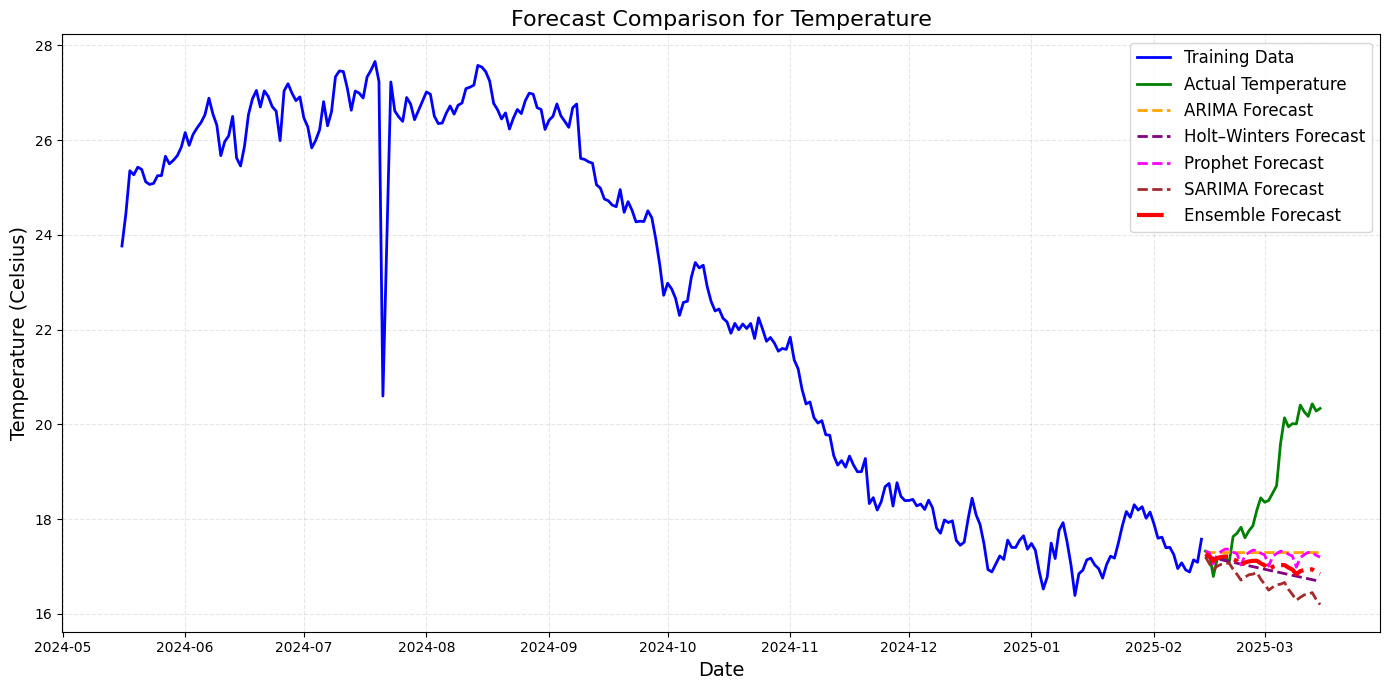

In [49]:
# Plot 1: Forecast Comparison
plt.figure(figsize=(14, 7))
plt.plot(train.index, train, label='Training Data', color='blue', linewidth=2)
plt.plot(test.index, test, label='Actual Temperature', color='green', linewidth=2)
plt.plot(test.index, arima_forecast, label='ARIMA Forecast', color='orange', linestyle='--', linewidth=2)
plt.plot(test.index, hw_forecast, label='Holt–Winters Forecast', color='purple', linestyle='--', linewidth=2)
plt.plot(test.index, prophet_forecast, label='Prophet Forecast', color='magenta', linestyle='--', linewidth=2)
plt.plot(test.index, sarima_forecast, label='SARIMA Forecast', color='brown', linestyle='--', linewidth=2)
plt.plot(test.index, ensemble_forecast, label='Ensemble Forecast', color='red', linestyle='-.', linewidth=3)
plt.xlabel("Date", fontsize=14)
plt.ylabel("Temperature (Celsius)", fontsize=14)
plt.title("Forecast Comparison for Temperature", fontsize=16)
plt.legend(fontsize=12)
plt.grid(True, linestyle='--', alpha=0.3)
plt.tight_layout()
plt.show()

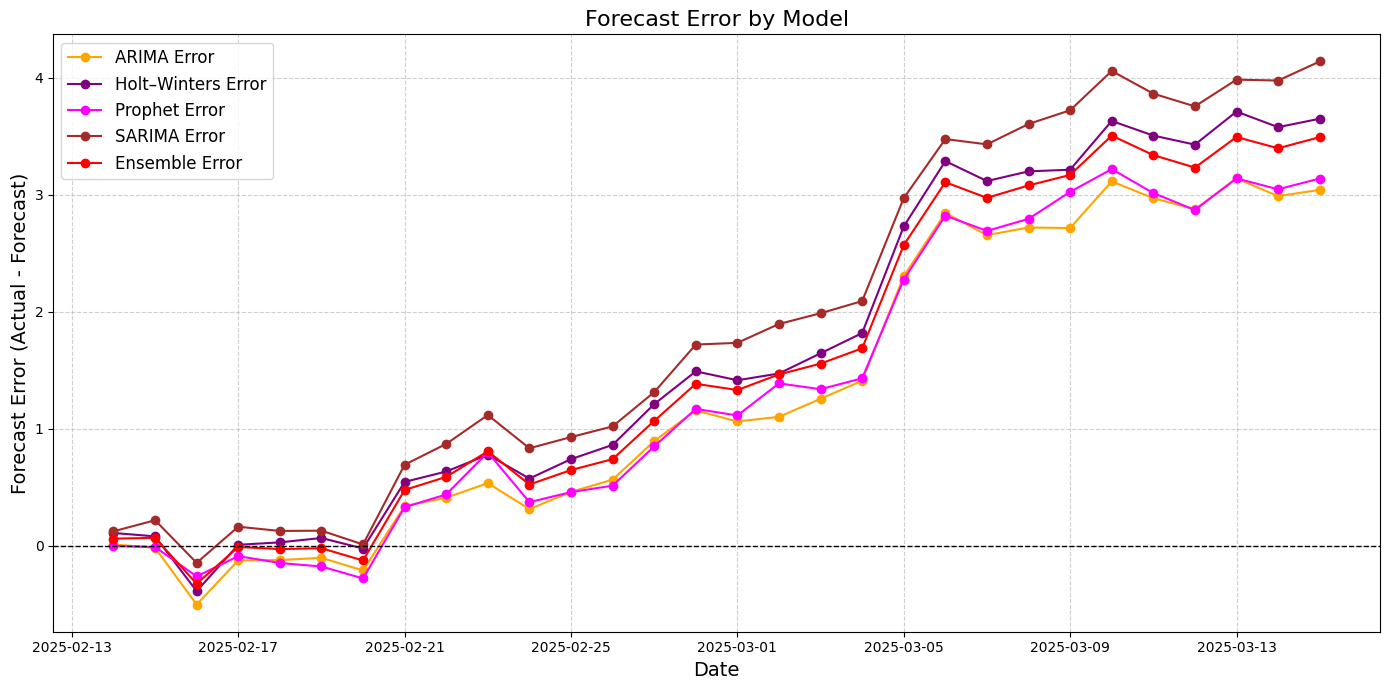

In [50]:
# Plot 2: Forecast Error Plot for Each Model
# Compute errors: actual minus forecast
error_arima = test - arima_forecast
error_hw = test - hw_forecast
error_prophet = test - prophet_forecast
error_sarima = test - sarima_forecast
error_ensemble = test - ensemble_forecast

plt.figure(figsize=(14, 7))
plt.plot(test.index, error_arima, label='ARIMA Error', marker='o', color='orange')
plt.plot(test.index, error_hw, label='Holt–Winters Error', marker='o', color='purple')
plt.plot(test.index, error_prophet, label='Prophet Error', marker='o', color='magenta')
plt.plot(test.index, error_sarima, label='SARIMA Error', marker='o', color='brown')
plt.plot(test.index, error_ensemble, label='Ensemble Error', marker='o', color='red')
plt.axhline(0, color='black', linewidth=1, linestyle='--')
plt.xlabel("Date", fontsize=14)
plt.ylabel("Forecast Error (Actual - Forecast)", fontsize=14)
plt.title("Forecast Error by Model", fontsize=16)
plt.legend(fontsize=12)
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

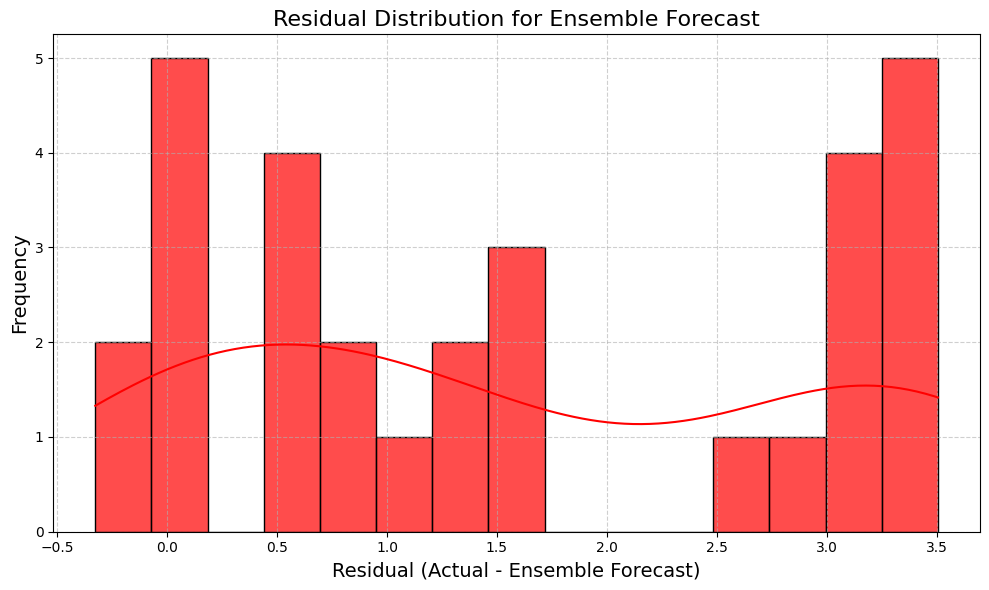

In [51]:
# Plot 3: Residual Distribution for Ensemble Forecast
residuals_ensemble = test - ensemble_forecast

plt.figure(figsize=(10, 6))
sns.histplot(residuals_ensemble, bins=15, kde=True, color='red', edgecolor='black', alpha=0.7)
plt.xlabel("Residual (Actual - Ensemble Forecast)", fontsize=14)
plt.ylabel("Frequency", fontsize=14)
plt.title("Residual Distribution for Ensemble Forecast", fontsize=16)
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

In [52]:
# Ensure the 'last_updated' column exists
if 'last_updated' not in df.columns:
    if 'last_updated_epoch' in df.columns:
        df['last_updated'] = pd.to_datetime(df['last_updated_epoch'], unit='s')
    else:
        raise KeyError("Neither 'last_updated' nor 'last_updated_epoch' exists in the DataFrame.")


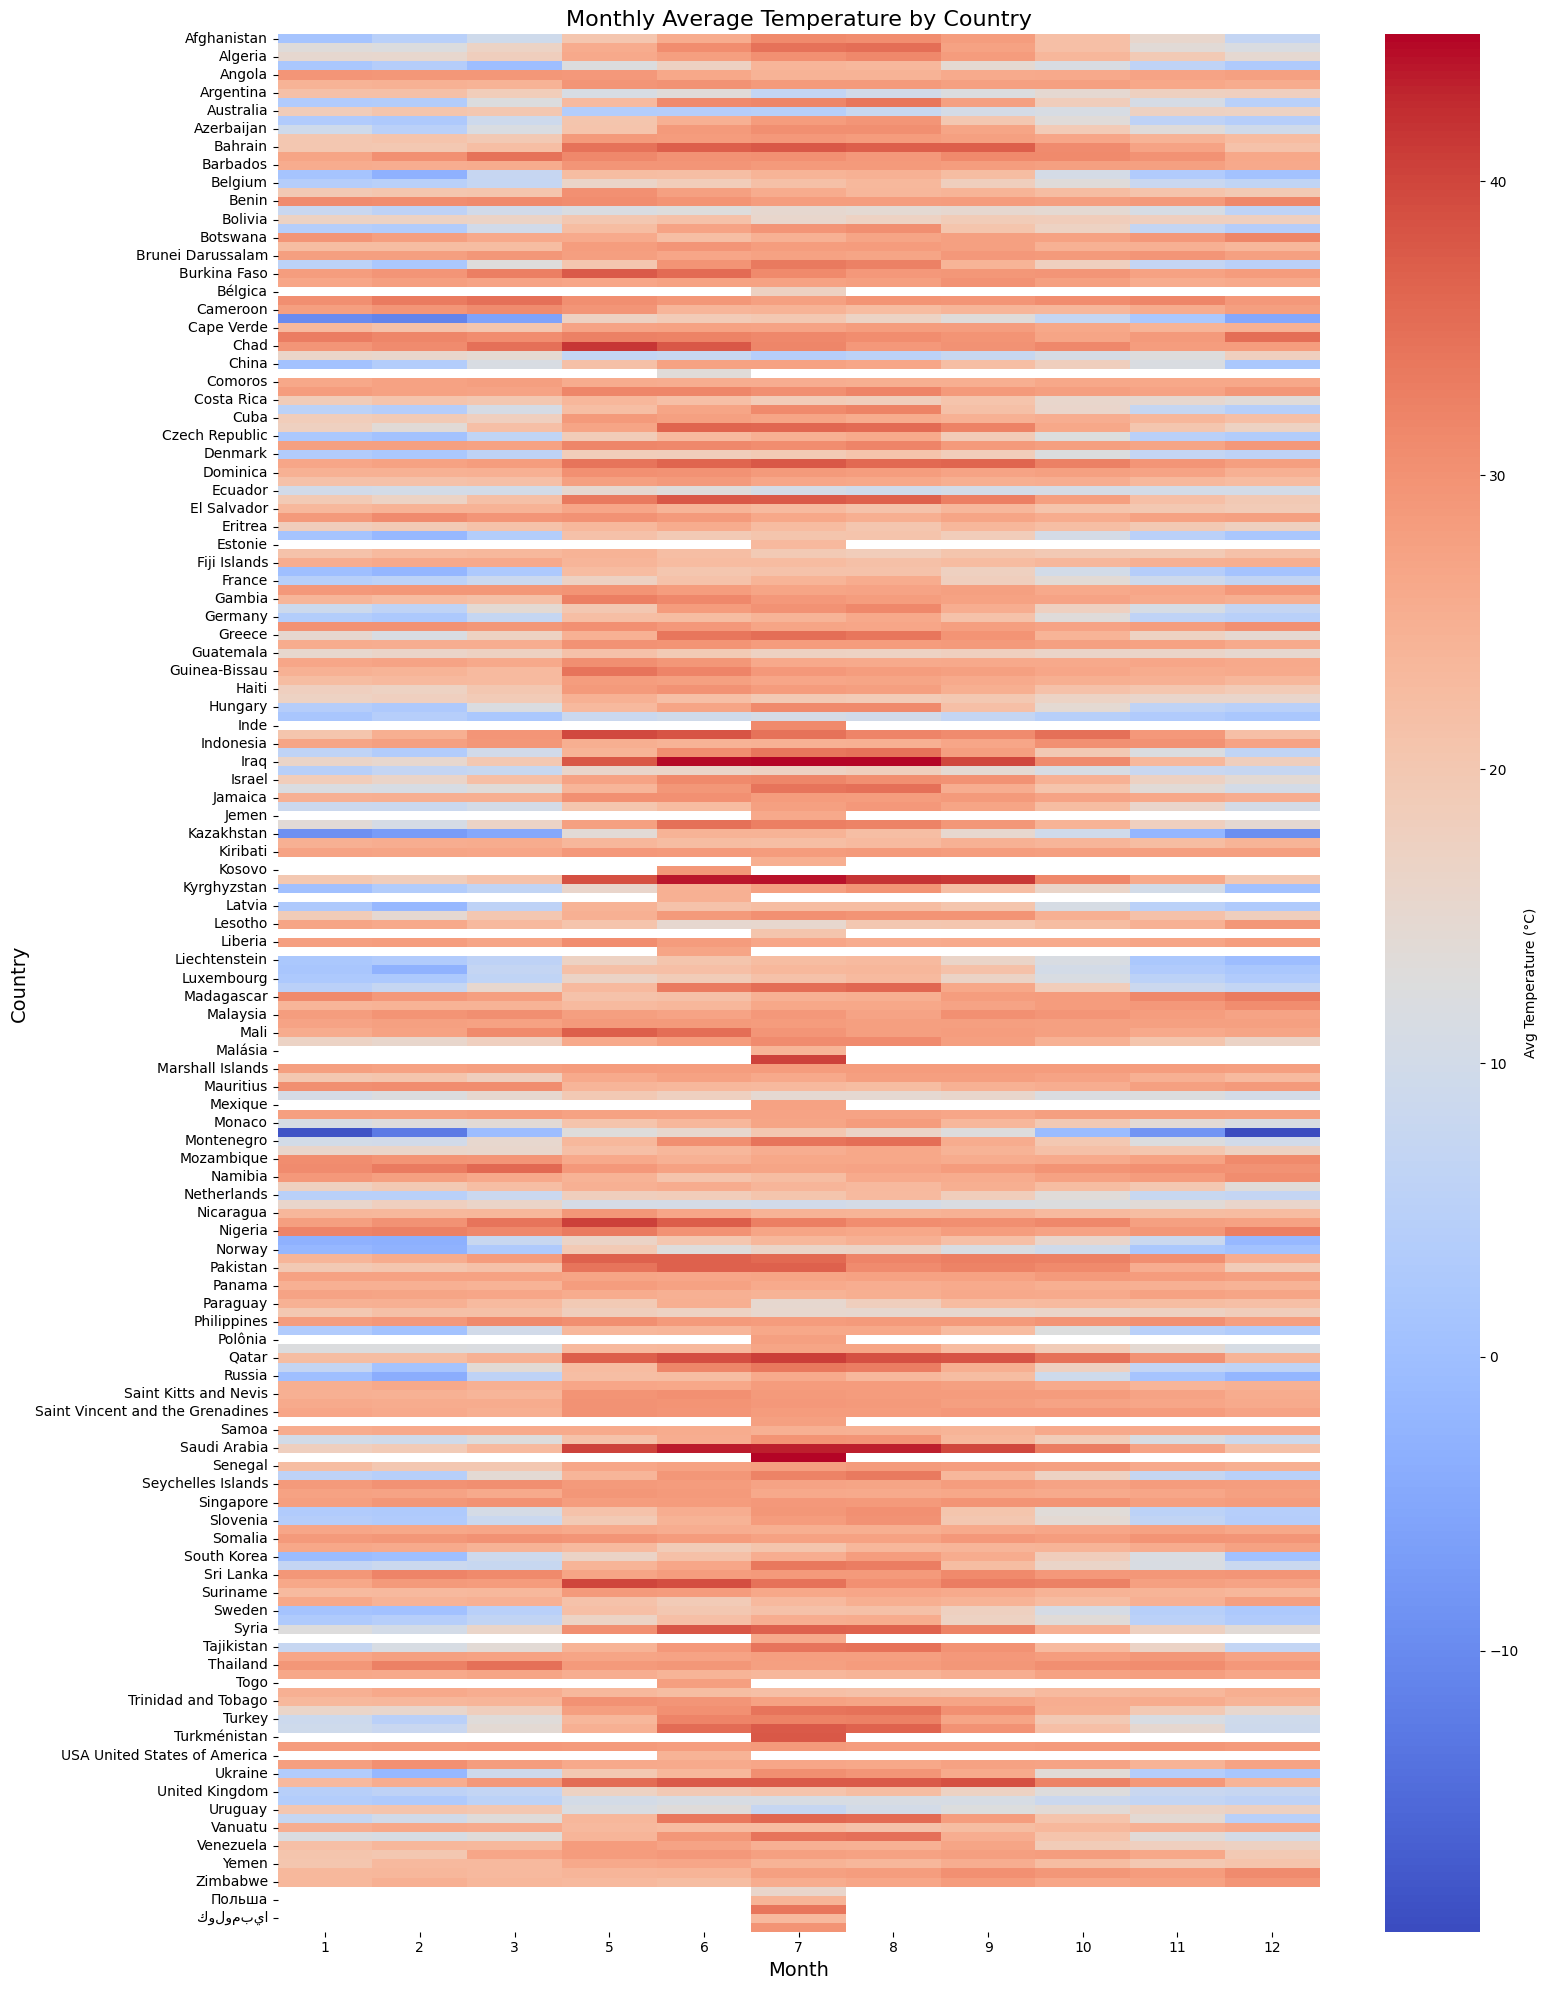

In [53]:
# -------------------------------
# Climate Analysis
# -------------------------------

# Compute monthly average temperature per country
df['month'] = df['last_updated'].dt.month
monthly_avg = df.groupby(['country', 'month'])['temperature_celsius'].mean().reset_index()

# Pivot the data: rows = country, columns = month, values = average temperature
monthly_pivot = monthly_avg.pivot(index='country', columns='month', values='temperature_celsius')

plt.figure(figsize=(16, 20))
sns.heatmap(monthly_pivot, cmap="coolwarm", cbar_kws={'label': 'Avg Temperature (°C)'})
plt.title("Monthly Average Temperature by Country", fontsize=16)
plt.xlabel("Month", fontsize=14)
plt.ylabel("Country", fontsize=14)
plt.tight_layout()
plt.show()


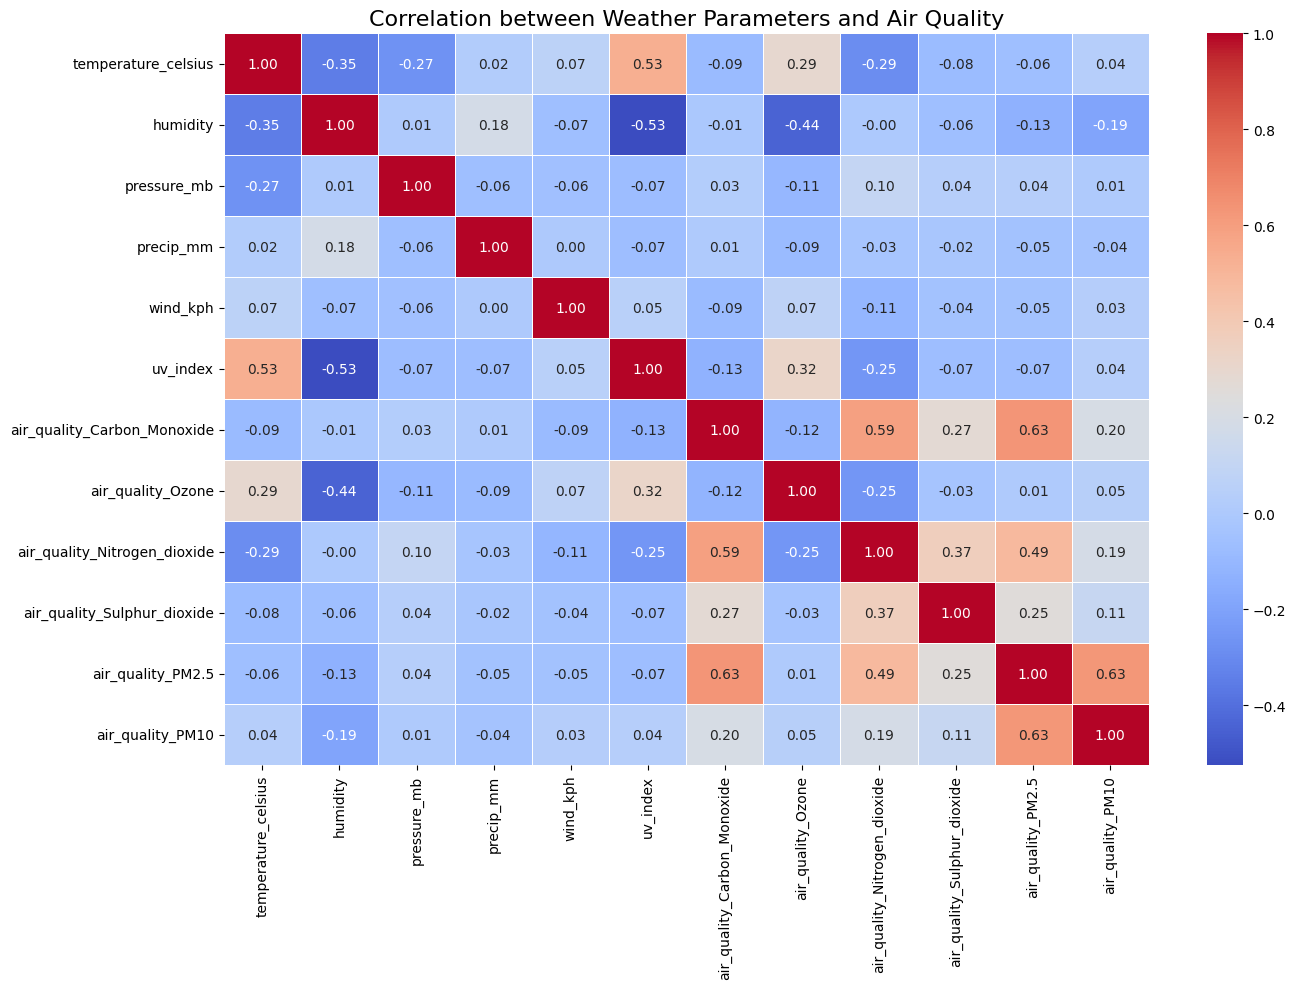

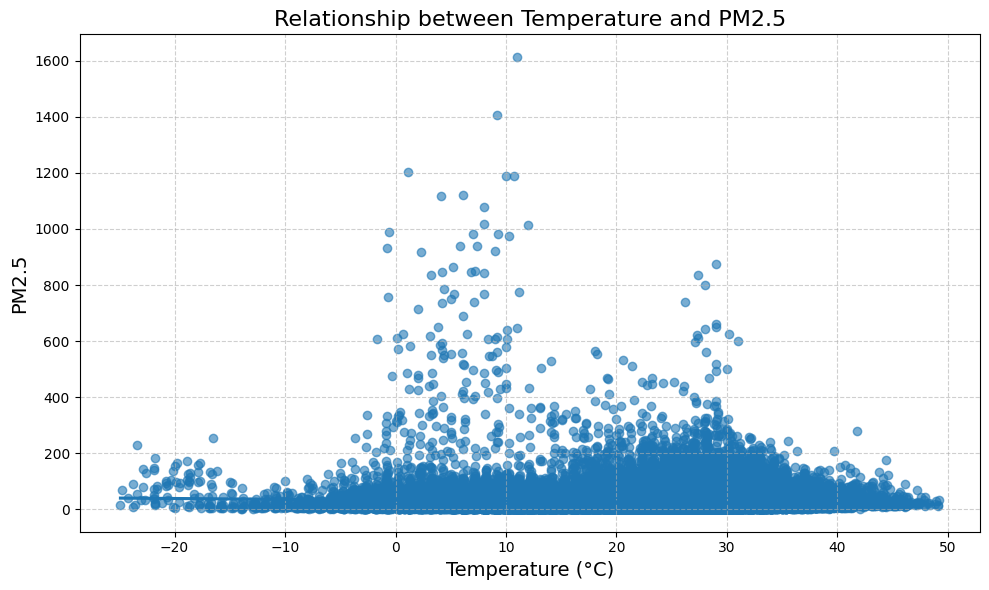

In [54]:
# -------------------------------
# Part 2: Environmental Impact
# Analyze air quality and its correlation with weather parameters.
# -------------------------------
env_cols = ['temperature_celsius', 'humidity', 'pressure_mb', 'precip_mm', 
            'wind_kph', 'uv_index', 'air_quality_Carbon_Monoxide', 'air_quality_Ozone', 
            'air_quality_Nitrogen_dioxide', 'air_quality_Sulphur_dioxide', 
            'air_quality_PM2.5', 'air_quality_PM10']

env_df = df[env_cols]

plt.figure(figsize=(14, 10))
sns.heatmap(env_df.corr(), cmap='coolwarm', annot=True, fmt=".2f", linewidths=0.5)
plt.title("Correlation between Weather Parameters and Air Quality", fontsize=16)
plt.tight_layout()
plt.show()

plt.figure(figsize=(10, 6))
sns.regplot(x='temperature_celsius', y='air_quality_PM2.5', data=env_df, scatter_kws={'alpha':0.6})
plt.xlabel("Temperature (°C)", fontsize=14)
plt.ylabel("PM2.5", fontsize=14)
plt.title("Relationship between Temperature and PM2.5", fontsize=16)
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

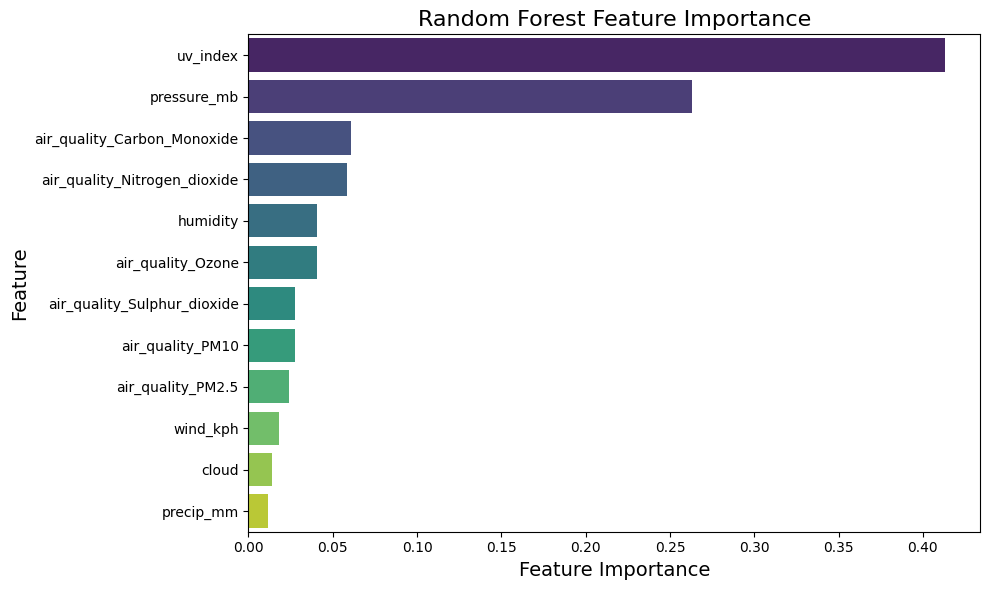

In [55]:
# -------------------------------
# Part 3: Feature Importance
# Apply different techniques to assess feature importance.
# Example: Predict temperature using a RandomForestRegressor.
# -------------------------------
features = ['humidity', 'pressure_mb', 'precip_mm', 'wind_kph', 'uv_index',
            'air_quality_Carbon_Monoxide', 'air_quality_Ozone', 'air_quality_Nitrogen_dioxide',
            'air_quality_Sulphur_dioxide', 'air_quality_PM2.5', 'air_quality_PM10', 'cloud']
target = 'temperature_celsius'

df_model = df[features + [target]].dropna()
X = df_model[features]
y = df_model[target]

rf = RandomForestRegressor(n_estimators=200, random_state=42)
rf.fit(X, y)

# Model-based Feature Importance
importances = rf.feature_importances_
feat_importance_df = pd.DataFrame({'feature': features, 'importance': importances}).sort_values(by='importance', ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(x='importance', y='feature', data=feat_importance_df, palette='viridis')
plt.xlabel("Feature Importance", fontsize=14)
plt.ylabel("Feature", fontsize=14)
plt.title("Random Forest Feature Importance", fontsize=16)
plt.tight_layout()
plt.show()


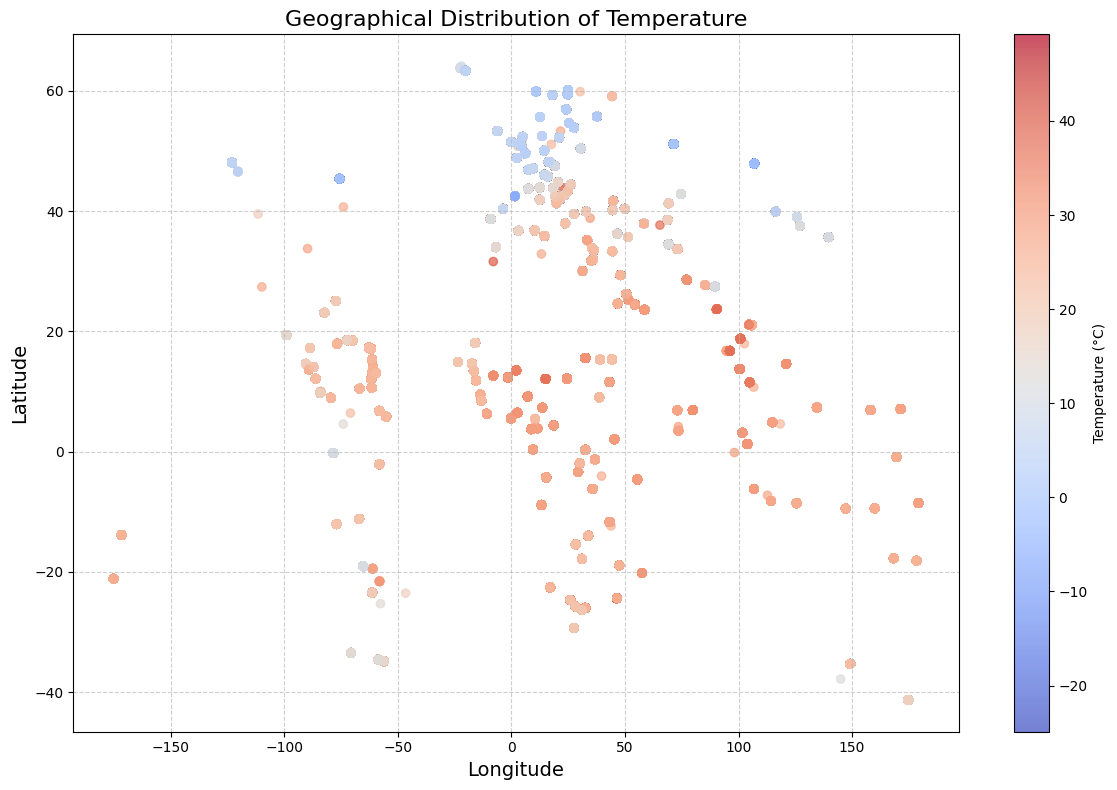

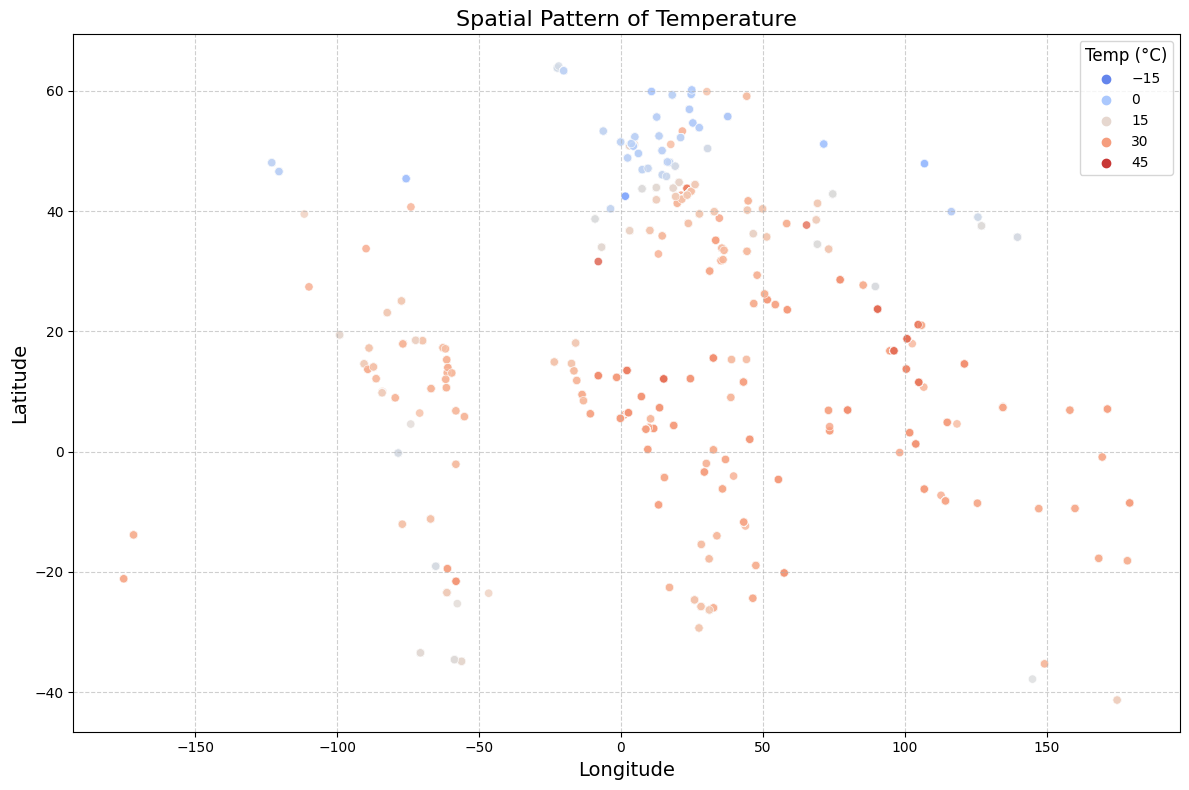

In [56]:
# -------------------------------
# Part 4: Spatial Analysis
# Analyze and visualize geographical patterns in the data.
# -------------------------------
plt.figure(figsize=(12, 8))
scatter = plt.scatter(df['longitude'], df['latitude'], c=df['temperature_celsius'], cmap='coolwarm', alpha=0.7)
plt.colorbar(scatter, label="Temperature (°C)")
plt.xlabel("Longitude", fontsize=14)
plt.ylabel("Latitude", fontsize=14)
plt.title("Geographical Distribution of Temperature", fontsize=16)
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

plt.figure(figsize=(12, 8))
sns.scatterplot(x='longitude', y='latitude', hue='temperature_celsius', data=df, palette='coolwarm', alpha=0.8, edgecolor='w')
plt.xlabel("Longitude", fontsize=14)
plt.ylabel("Latitude", fontsize=14)
plt.title("Spatial Pattern of Temperature", fontsize=16)
plt.legend(title="Temp (°C)", fontsize=10, title_fontsize=12)
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()